# Pumphouse and Almont East River Streamflow Comparison
- Create comparison plot for times when they align
- Create a linear model for the years they align

In [1]:
from dataretrieval import nwis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import datetime as dt

In [2]:
pumphouse_df = pd.read_csv('./multisite/data/streamflow/ph_discharge_wy2014_wy2018.csv', index_col=0)
pumphouse_df.index = pd.to_datetime(pumphouse_df.index, format='%Y-%m-%d')
pumphouse_df_pre_2017 = pumphouse_df.loc[dt.date(2014,5,1):dt.date(2016,9,30)]
pumphouse_df_post_2017 = pumphouse_df.loc[dt.date(2017,10,1):]

In [3]:
pumphouse_df_pre_2017.index

DatetimeIndex(['2014-05-01', '2014-05-02', '2014-05-03', '2014-05-04',
               '2014-05-05', '2014-05-06', '2014-05-07', '2014-05-08',
               '2014-05-09', '2014-05-10',
               ...
               '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24',
               '2016-09-25', '2016-09-26', '2016-09-27', '2016-09-28',
               '2016-09-29', '2016-09-30'],
              dtype='datetime64[ns]', name='date', length=884, freq=None)

In [4]:
almont_cms_df_pre = nwis.get_dv(sites=['09112500'], start='2014-05-01',end='2016-09-30')[0]['00060_Mean']/35.315
almont_cms_df_post = nwis.get_dv(sites=['09112500'], start='2017-10-01',end='2018-10-15')[0]['00060_Mean']/35.315
bcc_cms_df = nwis.get_dv(sites=['09112200'], start='2014-05-01',end='2016-10-15')[0]['00060_Mean']/35.315

almont_cms_df_pre.index = almont_cms_df_pre.index.date
almont_cms_df_post.index =almont_cms_df_post.index.date
slope, intercept, rvalue, _, _ = stats.linregress(x=almont_cms_df_pre[pumphouse_df_pre_2017.index.date],y=pumphouse_df_pre_2017.T)
print(slope)
print(intercept)

0.23090890597826277
-0.07313471407001249


In [5]:
x_pred = np.array([almont_cms_df_pre.min(), almont_cms_df_pre.max()])
y_pred = slope*x_pred + intercept

Text(0, 0.5, 'East River Discharge at Pumphouse (cms)')

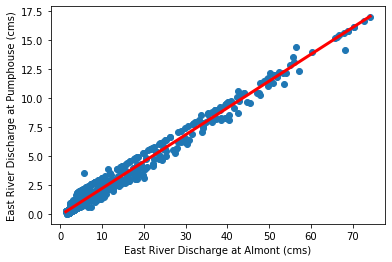

In [6]:
plt.scatter(almont_cms_df_pre[pumphouse_df_pre_2017.index],pumphouse_df_pre_2017)
plt.plot(x_pred,y_pred, color='red', lw=3, label='Best-Fit Line')
plt.xlabel('East River Discharge at Almont (cms)')
plt.ylabel('East River Discharge at Pumphouse (cms)')

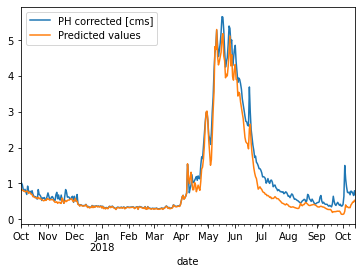

In [7]:
fig, ax = plt.subplots()

pumphouse_df_post_2017.plot(label='PH measured values', ax=ax)

y_pred = slope*almont_cms_df_post + intercept
y_pred.index = pd.to_datetime(y_pred.index)
y_pred.plot(ax=ax, label='Predicted values')
ax.legend()

In [8]:
NSE = 1 -((pumphouse_df_post_2017['PH corrected [cms]'] - y_pred.values)**2).sum()/((pumphouse_df_post_2017['PH corrected [cms]'].values - pumphouse_df_post_2017['PH corrected [cms]'].mean())**2).sum()
print(f'Nash-Sutcliffe Efficincy for the model is {NSE}')

Nash-Sutcliffe Efficincy for the model is 0.9539247303761428


In [87]:
# This function requires that the input is a pandas dataframe, with column names, and an integer index
# It returns a copy of the dataframe with an extra column added that has the Cunnane plotting positions
# Reference 2
def cunnane_quantile(df, column_name):
    '''This function will compute the Cunnane plotting position for the values in a column of a dataframe.
    It requres a pandas dataframe, and the column name of interest (a text string) as inputs.
    The output is a new dataframe, ranked (sorted) with an extra column with the plotting position.
    [Steven Pestana, spestana@uw.edu, Oct. 2020]'''
    
    # Rank all our values
    ranked_df = df.sort_values(by=[column_name]).reset_index()
    
    # Calculate the Cunnane plotting position
    ranked_df['cunnane_plotting_position'] = ((ranked_df.index + 1) - (2/5)) / (ranked_df[column_name].count() + (1/5))
        
    return ranked_df

No handles with labels found to put in legend.


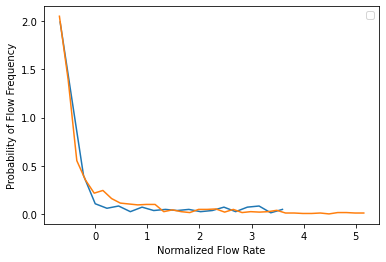

In [17]:
counts, bin_edges = np.histogram((almont_cms_df_post-almont_cms_df_post.mean())/almont_cms_df_post.std(), bins='sqrt', density=True)# using density=True to normalize, and the square root method to determine number of bins
plt.plot(bin_edges[:-1], 
            counts)
counts, bin_edges = np.histogram((pumphouse_df-pumphouse_df.mean())/pumphouse_df.std(), bins='sqrt', density=True)# using density=True to normalize, and the square root method to determine number of bins
plt.plot(bin_edges[:-1], 
            counts)
# Plot specifications
plt.ticklabel_format(style='plain')
plt.xlabel('Normalized Flow Rate')
plt.ylabel('Probability of Flow Frequency')

plt.legend()

Text(0, 0.5, 'frequency count')

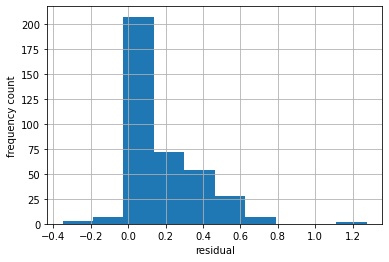

In [21]:
rmse = np.sqrt((pumphouse_df_post_2017['PH corrected [cms]'] - y_pred.values)**2).sum()/(len(y_pred))
residuals = (pumphouse_df_post_2017['PH corrected [cms]'] - y_pred.values)
residuals.hist()
plt.xlabel('residual')
plt.ylabel('frequency count')
# overall the model generally underpredicts the streamflow